## カテゴリデータを削除して実装する．
## 全てのデータを含むデータセットで試す．
## Accuracyや混合行列など他の指標で評価する．
## macro, microについても理解する．

In [1]:
from utils import *
print_version()

python:      3.10.11
sklearn:     1.2.2
tensorflow:  2.12.0
keras:       2.12.0
numpy:       1.23.5
pandas:      1.5.3


In [2]:
# 特徴量名の読み込み
with open("../dataset/kddcup.names") as fp:
    # 一行目は不要なので無視
    _ = fp.readline()
    # `:`より手前がラベルなので，その部分を抽出してリストに追加
    names = [line.split(':')[0] for line in fp]
print(f"特徴量の数：{len(names)}")
print(f"各特徴量の名前：{', '.join(names)}")

特徴量の数：41
各特徴量の名前：duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate


In [3]:
# データの読み込み
#　正解ラベルを追加
names.append("true_label")
data = pd.read_csv("../dataset/kddcup.data", names=names, index_col=False)
true_label = data.pop('true_label')

In [4]:
true_label_counts = true_label.value_counts()
true_label_counts

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: true_label, dtype: int64

In [5]:
# 正解ラベルのピリオドを外す．
true_label = true_label.map(lambda x: x.replace('.', ''))
true_label

0          normal
1          normal
2          normal
3          normal
4          normal
            ...  
4898426    normal
4898427    normal
4898428    normal
4898429    normal
4898430    normal
Name: true_label, Length: 4898431, dtype: object

### 攻撃の種類は，大まかに４種類(`Dos`, `U2R`, `R2L`, `Probe`)
### 後の学習プログラムのために，予め各クラスを定義しておく，
### class -> `Dos`, `U2R`, `R2L`, `Probe`
### label -> `duration`, `protocol_type`, `service`, `flag`, `src_bytes`, `dst_bytes`, `land`, `wrong_fragment`, `urgent`, `hot`, `num_failed_logins`, `logged_in`, `num_compromised`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `num_access_files`, `num_outbound_cmds`, `is_host_login`, `is_guest_login`, `count`, `srv_count`, `serror_rate`, `srv_serror_rate`, `rerror_rate`, `srv_rerror_rate`, `same_srv_rate`, `diff_srv_rate`, `srv_diff_host_rate`, `dst_host_count`, `dst_host_srv_count`, `dst_host_same_srv_rate`, `dst_host_diff_srv_rate`, `dst_host_same_src_port_rate`, `dst_host_srv_diff_host_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate`, `dst_host_rerror_rate`

In [6]:
# attack_class_labels -> key: class, value: list[label]
attack_class_labels = {
    'normal': ['normal'],
    'dos': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'],
    'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit'],
    'r2l': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster'],
    'probe': ['ipsweep', 'nmap', 'portsweep', 'satan']
}
# attack_class_label -> key: label, value: class
attack_label_class = {}
for c, labels in attack_class_labels.items():
    for label in labels:
        attack_label_class[label] = c
attack_label_class

{'normal': 'normal',
 'back': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'smurf': 'dos',
 'teardrop': 'dos',
 'buffer_overflow': 'u2r',
 'loadmodule': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'ipsweep': 'probe',
 'nmap': 'probe',
 'portsweep': 'probe',
 'satan': 'probe'}

In [7]:
# データの定義
data_x = data.copy()
true_labels = pd.DataFrame({
    'class': [attack_label_class[label] for label in true_label],
    'name': true_label,
    'label': [int(t_or_f) for t_or_f in true_label != 'normal']
})
data_y = true_labels['label'].copy()

### カテゴリーデータを削除
カテゴリデータは，ワンホットエンコーディングすると学習に大きく影響を受けてしまうため，特徴量から外す．

In [8]:
data_x = data_x.drop(columns=['protocol_type', 'service', 'flag'], axis=1)

In [9]:
print(f"データの総数：{len(data)}")
# 各クラスとそのクラスに属するラベルのデータ数
for c, labels in attack_class_labels.items():
    print(f"{c}: {len(true_label[true_labels['class'] == c])}")
    for l in labels:
        print(f"   {l}: {len(true_label[true_labels['name'] == l])}")

データの総数：4898431
normal: 972781
   normal: 972781
dos: 3883370
   back: 2203
   land: 21
   neptune: 1072017
   pod: 264
   smurf: 2807886
   teardrop: 979
u2r: 52
   buffer_overflow: 30
   loadmodule: 9
   perl: 3
   rootkit: 10
r2l: 1126
   ftp_write: 8
   guess_passwd: 53
   imap: 12
   multihop: 7
   phf: 4
   spy: 2
   warezclient: 1020
   warezmaster: 20
probe: 41102
   ipsweep: 12481
   nmap: 2316
   portsweep: 10413
   satan: 15892


In [10]:
print(f"正常ラベル：{len(true_label[true_labels['label'] == 0])}")
print(f"異常ラベル：{len(true_label[true_labels['label'] == 1])}")

正常ラベル：972781
異常ラベル：3925650


In [11]:
# 標準化
from sklearn.preprocessing import StandardScaler
data_x = pd.DataFrame(StandardScaler().fit_transform(data_x))

In [12]:
# 学習データと，検証データを2：1に分ける．
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, stratify=data_y, test_size=0.33, random_state=2018)

In [13]:
print(f"学習・正常ラベル：{np.sum(y_train == 0)}，学習・不正ラベル：{np.sum(y_train   == 1)}")
print(f"検証・正常ラベル：{np.sum(y_test == 0)}，検証・不正ラベル：{np.sum(y_test == 1)}")

学習・正常ラベル：651763，学習・不正ラベル：2630185
検証・正常ラベル：321018，検証・不正ラベル：1295465


In [14]:
params = {
    'task': 'train', # default
    'boosting': 'gbdt', #  default
    'objective': 'binary', # 2値分類：binary, 他クラス分類：multiclass
    'metric': 'binary_logloss', # 交差エントロピー誤差
    'learning_rate': 0.1,
    'num_leaves': 31, # ノードの数
    'verbose': -1,
    'seed': RANDOM_SEED
}

In [15]:
# k分割交差検証
#　`StratifiedKFold`は，，y_trainのラベル分布が近くなるように分割する．
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train.index, columns=['prediction']
)
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア


In [16]:
for t_idx, v_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_validation_fold = x_train.iloc[t_idx, :], x_train.iloc[v_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train.iloc[t_idx], y_train.iloc[v_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    gbm = lgb.train(params, lgb_train,
                    num_boost_round=1000, # 2000->1000
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(50)]
                    # 200-> 50
                    )
    y_train_pred = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_pred)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)

    training_scores.append(training_score)
    validation_scores.append(validation_score)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.000257404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's binary_logloss: 0.000170135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.000251176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.000248926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.000293408


In [17]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(x_test,
                                         num_iteration=gbm.best_iteration), index=x_test.index)
predictions

2828660    0.999981
4825191    0.000072
4735908    0.999981
2100416    0.999981
1274026    0.999981
             ...   
3406297    0.000077
2682103    0.999981
3010182    0.999981
1495098    0.999981
2356085    0.999981
Length: 1616483, dtype: float64

In [18]:
# 閾値を0.5とする．
y_pred = np.where(predictions < 0.5, 0, 1)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score

# モデルの評価
# acc: 正答率
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc}")


# log loss
log_loss_light_gbm_gradient_boosting = log_loss(y_test, predictions)
print(f'Light GBM Gradient Boosting Log loss: {log_loss_light_gbm_gradient_boosting}')

# AUC
auc = roc_auc_score(y_test, predictions)
print(f"AUC: {auc}")

# precision score
print(f"precision score (micro): {precision_score(y_test, y_pred, average='micro')}")
print(f"precision score (macro): {precision_score(y_test, y_pred, average='macro')}")

Accuracy score: 0.9999300951510162
Light GBM Gradient Boosting Log loss: 0.00028903618874890204
AUC: 0.9999981129618384
precision score (micro): 0.9999300951510162
precision score (macro): 0.9998685306157578


In [20]:
# 混合行列で表示
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, digits=6))
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))
tn, tp, fn, fp = confusion_matrix(y_test, y_pred).flatten()
print(f'正常ラベルを正常と判断：{tn}')
print(f'正常ラベルを不正と判断：{tp}')
print(f'不正ラベルを正常と判断：{fn}')
print(f'不正ラベルを不正と判断：{fp}')
print(f'正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): {tn / (tn + tp)}')
print(f'不正ラベルを不正と予測した割合(不正ラベルの正解率): {fp / (fn + fp)}')
total = tn + tp + fn + fp
print(f"適合率(マイクロ平均): { (tn + tp) / total * (tn/(tn+tp)) + (fn + fp) / total * (fp / (fn + fp))}")
print(f"適合率(マクロ平均): {0.5 * (tn/(tn+tp)) + 0.5 * (fp / (fn + fp))}")



              precision    recall  f1-score   support

           0   0.999766  0.999882  0.999824    321018
           1   0.999971  0.999942  0.999956   1295465

    accuracy                       0.999930   1616483
   macro avg   0.999869  0.999912  0.999890   1616483
weighted avg   0.999930  0.999930  0.999930   1616483

[[ 320980      38]
 [     75 1295390]]
正常ラベルを正常と判断：320980
正常ラベルを不正と判断：38
不正ラベルを正常と判断：75
不正ラベルを不正と判断：1295390
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.9998816265754569
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.9999421057303748
適合率(マイクロ平均): 0.9999300951510162
適合率(マクロ平均): 0.9999118661529158


In [21]:
data_x.shape

(4898431, 38)

In [22]:
incorrect_data = true_labels.iloc[y_test.index[y_test != y_pred]]['class']
incorrect_data

409161     normal
264363      probe
1381890    normal
808418      probe
4511467    normal
            ...  
396614        r2l
406612      probe
1381089    normal
1461036     probe
894866      probe
Name: class, Length: 113, dtype: object

In [23]:
incorrect_data.value_counts()

normal    38
probe     38
r2l       20
u2r        9
dos        8
Name: class, dtype: int64

In [24]:
true_labels['class'].value_counts()

dos       3883370
normal     972781
probe       41102
r2l          1126
u2r            52
Name: class, dtype: int64

### Accuracyがこれほど高くなる理由はわからない．
### r2lは，20/1126, u2rは，9/52と比較的誤った結果の割合が多い．
### 全体のデータ量が489万件で，そのうちDOSの異常データが388万件のため，DOSのデータに引っ張られている？
###

## 未完備オートエンコーダで試す．
- 未完備オートエンコーダで，正常なラベルデータのみを用いて学習する．
- 入力は，38次元
- 隠れ層は，38 -> 19 -> 10 -> 19 -> 38　とする．
- 活性化関数は，ReLU
- 最適化器は．adam
- 誤差関数は，平均二乗誤差(mean_squared_error)

In [25]:
model = keras.Sequential([
    Dense(units=19, activation='relu', input_dim=38),
    Dense(units=10, activation='relu'),
    Dense(units=19, activation='relu'),
    Dense(units=38, activation='relu'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                741       
                                                                 
 dense_1 (Dense)             (None, 10)                200       
                                                                 
 dense_2 (Dense)             (None, 19)                209       
                                                                 
 dense_3 (Dense)             (None, 38)                760       
                                                                 
Total params: 1,910
Trainable params: 1,910
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [27]:
# AutoEncoder用に，正常ラベルのみのDataFrameを定義
x_train_ae = x_train[y_train == 0]
y_train_ae = y_train[y_train == 0]
model.fit(x=x_train_ae, y=x_train_ae, epochs=5, batch_size=32, shuffle=True, validation_split=0.20)

Epoch 1/5


2023-07-04 09:42:49.524876: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16295/16295 [==============================] - 9s 518us/step - loss: 1.5363 - accuracy: 0.9248 - val_loss: 1.2164 - val_accuracy: 0.9320
Epoch 2/5
16295/16295 [==============================] - 9s 533us/step - loss: 1.5024 - accuracy: 0.9418 - val_loss: 1.1944 - val_accuracy: 0.9555
Epoch 3/5
16295/16295 [==============================] - 9s 524us/step - loss: 1.4959 - accuracy: 0.9409 - val_loss: 1.1947 - val_accuracy: 0.9392
Epoch 4/5
16295/16295 [==============================] - 8s 512us/step - loss: 1.4957 - accuracy: 0.9410 - val_loss: 1.1967 - val_accuracy: 0.9587
Epoch 5/5
16295/16295 [==============================] - 9s 531us/step - loss: 1.4908 - accuracy: 0.9484 - val_loss: 1.1843 - val_accuracy: 0.9598


In [28]:
# 検証データの特徴量を再現したデータ
predicted_x_test = model.predict(x_test)

50516/50516 [==============================] - 13s 248us/step


In [29]:
# TODO: バグあり 19行目で`KeyError`が発生
def precision_by_recall(data_y_: pd.Series, threshold: float):
    """
    あるレベルの再現率(Recall)に対する適合率(Precision)を求める．
    再現率 = 真陽性 / (真陽性 + 偽陰性)
    適合率 = 真陽性　/ (真陽性 + 偽陽性)
    不正ラベルのうち，実際に検出できた不正の割合（再現率）が
    :param df:
    :param column:
    :param threshold:
    :return:
    Example:
        threshold = 0.4の場合，40％の再現率を達成した際の適合率
    """
    threshold_value = threshold * data_y_.sum()  # 不正ラベルの個数
    i = 0
    j = 0
    while i <= threshold_value:
        if data_y_[j] == 1:
            i += 1
        j += 1
    return i / j


[2.00000000e+00 1.00000000e+00 6.22292698e-02 ... 8.82000147e-08
 8.40813050e-08 0.00000000e+00]


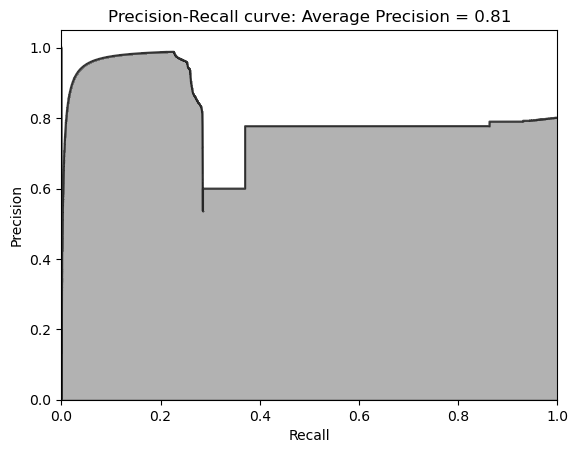

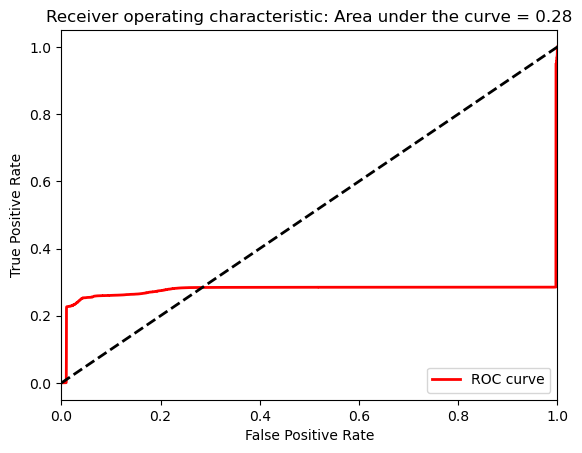

In [30]:
errors = reconstruction_errors(x_test, predicted_x_test)
plot_results(y_test, errors)
# precision = precision_by_recall(y_test, 0.75)
# print(f'Precision at 75% recall {round(precision, 4)}')

In [31]:
# 再構成誤差の閾値を変化させて，不正ラベルの適合率を調べる．
thresholds = np.arange(0.000001, 0.0001, 0.000001)
for threshold in thresholds:
    # 閾値よりも大きい再構成誤差のデータ（不正と判断したデータ）のインデックスと正解ラベル
    y_pred_as_abnormal = y_test[errors[errors > threshold].index]
    # 不正のうち不正と判断したもの
    fp = len(y_test[y_pred_as_abnormal[y_pred_as_abnormal == 1].index])
    # 正常のうち不正と判断したもの
    tp = len(y_test[y_pred_as_abnormal[y_pred_as_abnormal == 0].index])
    # 正常のうち正常と判断したもの
    tn = len(y_test[y_test == 0]) - tp
    # 不正のうち正常と判断したもの
    fn = len(y_test[y_test == 1]) - tp
    print()
    print(f"threshold:{round(threshold, 7)} tn: {tn} tp: {tp} fn: {fn} fp: {fp}")
    print(f'正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): {tn / (tn + tp)}')
    print(f'不正ラベルを不正と予測した割合(不正ラベルの正解率): {fp / (fn + fp)}')
    total = tn + tp + fn + fp
    print(f"適合率(マイクロ平均): { (tn + tp) / total * (tn/(tn+tp)) + (fn + fp) / total * (fp / (fn + fp))}")
    print(f"適合率(マクロ平均): {0.5 * (tn/(tn+tp)) + 0.5 * (fp / (fn + fp))}")



threshold:1e-06 tn: 1604 tp: 319414 fn: 976051 fp: 369392
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.004996604551769683
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.27455046404790096
適合率(マイクロ平均): 0.22262507193387665
適合率(マクロ平均): 0.13977353429983533

threshold:2e-06 tn: 124774 tp: 196244 fn: 1099221 fp: 368964
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.38868225457762495
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.2513062045995566
適合率(マイクロ平均): 0.27595415388863087
適合率(マクロ平均): 0.3199942295885908

threshold:3e-06 tn: 153955 tp: 167063 fn: 1128402 fp: 368818
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.47958369935642237
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.24633520791867594
適合率(マイクロ平均): 0.2875162657473884
適合率(マクロ平均): 0.36295945363754917

threshold:4e-06 tn: 199731 tp: 121287 fn: 1174178 fp: 368594
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.6221800646692709
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.2389167031810274
適合率(マイクロ平均): 0.3049297399385124
適合率(マクロ平均): 0.43054838392514916

threshold:5e-06 tn: 235526 tp: 85492 fn: 1209973 fp: 367826
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.73368

threshold:3e-06 tn: 200471 tp: 120547 fn: 1174918 fp: 368082
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.6244852313577431
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.23854957874270902
適合率(マイクロ平均): 0.30501475844117387
適合率(マクロ平均): 0.43151740505022607

threshold:4e-06 tn: 252148 tp: 68870 fn: 1226595 fp: 342977
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.7854637434660985
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.21851625793528426
適合率(マイクロ平均): 0.31478268688610433
適合率(マクロ平均): 0.5019900007006913

threshold:5e-06 tn: 314581 tp: 6437 fn: 1289028 fp: 297488
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.9799481649004106
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.18751024256925236
適合率(マイクロ平均): 0.3208692479400105
適合率(マクロ平均): 0.5837292037348315

threshold:6e-06 tn: 318383 tp: 2635 fn: 1292830 fp: 295601
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.9917917375349669
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.18609621695874734
適合率(マイクロ平均): 0.3215503530075954
適合率(マクロ平均): 0.5889439772468571

threshold:7e-06 tn: 318690 tp: 2328 fn: 1293137 fp: 295294
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.9927480702016709
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.18590294447791564
適合率(マイクロ平均): 0.3215503530075954
適合率(マクロ平均): 0.5893255073397933

threshold:8e-06 tn: 318771 tp: 2247 fn: 1293218 fp: 275805
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.9930003925013551
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.17578136203229652
適合率(マイクロ平均): 0.3145836518890331
適合率(マクロ平均): 0.5843908772668258

threshold:9e-06 tn: 318807 tp: 2211 fn: 1293254 fp: 8776
正常ラベルを正常と予測した割合(正常ラベルの適合率): 0.9931125357456592
不正ラベルを不正と予測した割合(不正ラベルの適合率): 0.006740244080397533
適合率(マイクロ平均): 0.20183198525243864
適合率(マクロ平均): 0.49992638991302835

## オートエンコーダによる再構成誤差を用いた不正検知結果
#### 78.5％を正しく正常と判断し，不正を検知できた割合は21.8%
#### 98%を正しく正常と判断し，不正を検知できた割合は18.6%

## 考察
#### 再構成誤差が小さすぎる -> 隠れ層の次元数を大幅に減らすことで，誤差を大きくできるのでは？


In [34]:
model_2 = keras.Sequential([
    Dense(units=10, activation='relu', input_dim=38),
    Dense(units=5, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=38, activation='relu'),
])
model_2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                390       
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 10)                60        
                                                                 
 dense_15 (Dense)            (None, 38)                418       
                                                                 
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# AutoEncoder用に，正常ラベルのみのDataFrameを定義
x_train_ae = x_train[y_train == 0]
y_train_ae = y_train[y_train == 0]
model.fit(x=x_train_ae, y=x_train_ae, epochs=5, batch_size=32, shuffle=True, validation_split=0.20)


Epoch 1/5
16295/16295 [==============================] - 8s 505us/step - loss: 1.6855 - accuracy: 0.8434 - val_loss: 1.2381 - val_accuracy: 0.8600
Epoch 2/5
16295/16295 [==============================] - 8s 467us/step - loss: 1.5401 - accuracy: 0.8575 - val_loss: 1.0840 - val_accuracy: 0.8599
Epoch 3/5
16295/16295 [==============================] - 8s 464us/step - loss: 1.5033 - accuracy: 0.8574 - val_loss: 1.0826 - val_accuracy: 0.8590
Epoch 4/5
16295/16295 [==============================] - 8s 493us/step - loss: 1.5013 - accuracy: 0.8581 - val_loss: 1.0835 - val_accuracy: 0.8604
Epoch 5/5
16295/16295 [==============================] - 8s 480us/step - loss: 1.5005 - accuracy: 0.8573 - val_loss: 1.0809 - val_accuracy: 0.8604


In [40]:
# 検証データの特徴量を再現したデータ
predicted_x_test = model_2.predict(x_test)


50516/50516 [==============================] - 13s 252us/step


[2.00000000e+00 1.00000000e+00 4.96552310e-02 ... 1.21339874e-07
 9.99085444e-08 0.00000000e+00]


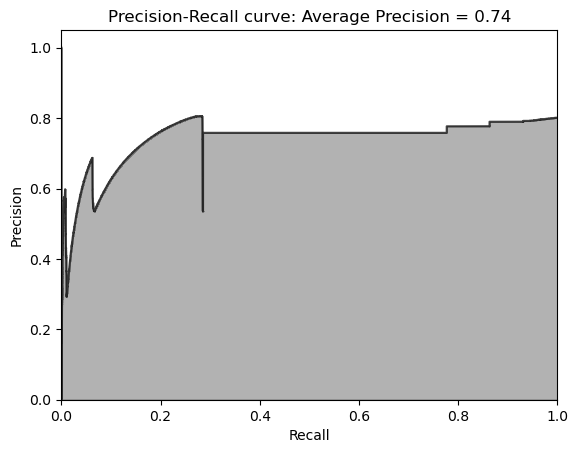

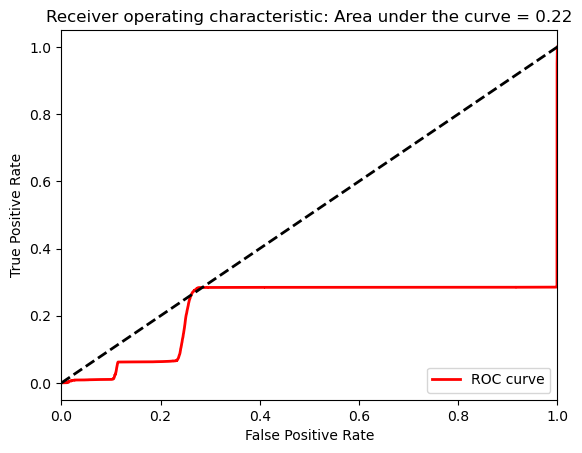

In [41]:
errors = reconstruction_errors(x_test, predicted_x_test)
plot_results(y_test, errors)


In [46]:
# 再構成誤差の閾値を変化させて，不正ラベルの適合率を調べる．
thresholds = np.arange(0.000005, 0.0003, 0.000005)
for threshold in thresholds:
    # 閾値よりも大きい再構成誤差のデータ（不正と判断したデータ）のインデックスと正解ラベル
    y_pred_as_abnormal = y_test[errors[errors > threshold].index]
    # 不正のうち不正と判断したもの
    fp = len(y_test[y_pred_as_abnormal[y_pred_as_abnormal == 1].index])
    # 正常のうち不正と判断したもの
    tp = len(y_test[y_pred_as_abnormal[y_pred_as_abnormal == 0].index])
    # 正常のうち正常と判断したもの
    tn = len(y_test[y_test == 0]) - tp
    # 不正のうち正常と判断したもの
    fn = len(y_test[y_test == 1]) - tp
    print()
    print(f"threshold:{round(threshold, 7)} tn: {tn} tp: {tp} fn: {fn} fp: {fp}")
    print(f'正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): {tn / (tn + tp)}')
    print(f'不正ラベルを不正と予測した割合(不正ラベルの正解率): {fp / (fn + fp)}')
    total = tn + tp + fn + fp
    print(f"適合率(マイクロ平均): { (tn + tp) / total * (tn/(tn+tp)) + (fn + fp) / total * (fp / (fn + fp))}")
    print(f"適合率(マクロ平均): {0.5 * (tn/(tn+tp)) + 0.5 * (fp / (fn + fp))}")



threshold:5e-06 tn: 152990 tp: 168028 fn: 1127437 fp: 368607
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.47657763739104975
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.24638780677573655
適合率(マイクロ平均): 0.28705514726520065
適合率(マクロ平均): 0.36148272208339316

threshold:1e-05 tn: 252521 tp: 68497 fn: 1226968 fp: 83026
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.7866256720806933
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.06337891623931102
適合率(マイクロ平均): 0.205729326332363
適合率(マクロ平均): 0.4250022941600022

threshold:1.5e-05 tn: 262001 tp: 59017 fn: 1236448 fp: 81363
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.8161567264140952
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.06174102356104176
適合率(マイクロ平均): 0.2095178935691277
適合率(マクロ平均): 0.43894887498756846

threshold:2e-05 tn: 283431 tp: 37587 fn: 1257878 fp: 80815
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.8829131076762051
不正ラベルを不正と予測した割合(不正ラベルの正解率): 0.06036858338693039
適合率(マイクロ平均): 0.21946350900849607
適合率(マクロ平均): 0.47164084553156777

threshold:2.5e-05 tn: 298541 tp: 22477 fn: 1272988 fp: 12834
正常ラベルを正常と予測した割合(正常ラベルの正解率，再現率): 0.9299821

#### 隠れ層を小さくすると逆に精度は下がった

/Users/satun/DataspellProjects/ml/kdd99
